In [1]:
!pip -qq install split-folders tqdm timm xgboost
!pip install -qq pytorch-metric-learning[with-hooks]

In [2]:
import os
import glob
import cv2
import splitfolders
import torch
import torchvision
import time
import copy
import random
import shutil
import itertools
import xgboost
import logging
import timm

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 12)

from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
from sklearn.cluster import OPTICS, KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import normalize
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    silhouette_score,
    accuracy_score
)


from torchvision.io import ImageReadMode, read_image
from torchvision.transforms import (
    Compose,
    Lambda,
    Normalize,
    AutoAugment,
    AutoAugmentPolicy,
    Resize,
    ToTensor,
)

import pytorch_metric_learning
import pytorch_metric_learning.utils.logging_presets as LP
from pytorch_metric_learning.utils import common_functions
from pytorch_metric_learning import losses, miners, samplers, testers, trainers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.utils.inference import InferenceModel
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Tested on torch==1.11.0, torchvision==0.12.0, pytorch_metric_learning==1.6.2
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
print("pytorch_metric_learning Version", pytorch_metric_learning.__version__)

PyTorch Version:  1.11.0
Torchvision Version:  0.12.0
pytorch_metric_learning Version 1.6.2


# Data analysis
* See this section in main notebook

## Solution #2
Arcface + Boosting

Motivation:  The [metric learning techniques](https://hav4ik.github.io/articles/deep-metric-learning-survey) will probably perform better than tha classic CNN as they tend to separate clusters as much as possible.

[source #2](https://towardsdatascience.com/the-why-and-the-how-of-deep-metric-learning-e70e16e199c0)

## Prepare data

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
splitfolders.fixed(
    "../input/bj-demo/images",
    output="/kaggle/temp/trainval_test",
    oversample=False,
    seed=42,
    fixed=8,
    group_prefix=None,
    move=False,
)
!mv /kaggle/temp/trainval_test/val /kaggle/temp/test
!mv /kaggle/temp/trainval_test/train /kaggle/temp/trainval
!rm -R /kaggle/temp/trainval_test

Copying files: 1422 files [00:01, 992.33 files/s] 


mv: cannot move '/kaggle/temp/trainval_test/val' to '/kaggle/temp/test/val': Directory not empty
mv: cannot move '/kaggle/temp/trainval_test/train' to '/kaggle/temp/trainval/train': Directory not empty


## Parameters

In [5]:
MODEL_NAME = "tf_efficientnet_b6_ns"
N_CLASSES = 8
OUTPUT_SIZE = 2304
EMBEDDING_SIZE = 512
N_EPOCH = 60
BATCH_SIZE = 16
ACCUMULATION_STEPS = int(256 / BATCH_SIZE)
MODEL_LR = 1e-5
PCT_START = 0.3
PATIENCE = 5
N_WORKER = 2
N_NEIGHBOURS = 750


## Directories

In [6]:
TRAIN_DIR = "/kaggle/temp/trainval"
TEST_DIR = "/kaggle/temp/test"
LOG_DIR = "../logs/{}".format(MODEL_NAME)
MODEL_DIR = "../models/{}".format(MODEL_NAME)

## Dataset

In [7]:
class PictureDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        image_dir: str,
        return_labels=True,
    ):
        self.df = df
        self.images = self.df["image"]
        self.image_dir = image_dir
        self.image_transform = Compose(
            [
                Resize((384, 384)),
                AutoAugment(AutoAugmentPolicy.IMAGENET),
                Lambda(lambda x: x / 255),
            ]
        )
        self.return_labels = return_labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image_path = os.path.join(self.image_dir, self.images.iloc[idx])
        image = read_image(path=image_path)
        image = self.image_transform(image)

        if self.return_labels:
            label = self.df["label"].iloc[idx]
            return image, label
        else:
            return image

## Data Split


In [8]:
file_paths = glob.glob(os.path.join(TRAIN_DIR, "*/*.jpg"))
file_labels = [x.split("/")[4] for x in file_paths]
df = pd.DataFrame({"image": file_paths, "individual_id": file_labels})
df["label"] = df.groupby("individual_id").ngroup()
df["label"].describe()
df.head()

,image,individual_id,label
0,/kaggle/temp/trainval/Cubism/aleksandra-ekster...,Cubism,1
1,/kaggle/temp/trainval/Cubism/carlos-merida_fac...,Cubism,1
2,/kaggle/temp/trainval/Cubism/jury-annenkov_por...,Cubism,1
3,/kaggle/temp/trainval/Cubism/man-ray_untitled-...,Cubism,1
4,/kaggle/temp/trainval/Cubism/gosta-adrian-nils...,Cubism,1


In [9]:
LABEL_TO_CLASSNUM = {}
for i in df["individual_id"].unique():
    classnum = df[df["individual_id"] == i].iloc[0]["label"]
    LABEL_TO_CLASSNUM[i] = classnum
CLASSNUM_TO_LABEL = {v: k for k, v in LABEL_TO_CLASSNUM.items()}

In [10]:
valid_proportion = 0.05

valid_df = df.sample(frac=valid_proportion, replace=False, random_state=1).copy()
train_df = df[~df["image"].isin(valid_df["image"])].copy()
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

In [11]:
train_dataset = PictureDataset(df=train_df, image_dir=TRAIN_DIR, return_labels=True)
valid_dataset = PictureDataset(df=valid_df, image_dir=TRAIN_DIR, return_labels=True)
len(valid_dataset), len(train_dataset)

(68, 1290)

In [12]:
dataset_dict = {"train": train_dataset, "val": valid_dataset}

## Model Setup
We need to specify three components to build our model:

- Trunk
- Embedder
- Loss

In [13]:
trunk = timm.create_model(MODEL_NAME, pretrained=True)
trunk.classifier = common_functions.Identity()
trunk = trunk.to(device)
trunk_optimizer = torch.optim.SGD(trunk.parameters(), lr=MODEL_LR, momentum=0.9)
trunk_schedule = torch.optim.lr_scheduler.OneCycleLR(
    trunk_optimizer,
    max_lr=MODEL_LR,
    total_steps=N_EPOCH * int(len(train_dataset) / BATCH_SIZE),
    pct_start=PCT_START,
)

In [14]:
embedder = torch.nn.Linear(OUTPUT_SIZE, EMBEDDING_SIZE).to(device)
embedder_optimizer = torch.optim.SGD(trunk.parameters(), lr=MODEL_LR, momentum=0.9)
embedder_schedule = torch.optim.lr_scheduler.OneCycleLR(
    embedder_optimizer,
    max_lr=MODEL_LR,
    total_steps=N_EPOCH * int(len(train_dataset) / BATCH_SIZE),
    pct_start=PCT_START,
)

In [15]:
loss_func = losses.ArcFaceLoss(num_classes=N_CLASSES, embedding_size=EMBEDDING_SIZE).to(
    device
)
loss_optimizer = torch.optim.SGD(trunk.parameters(), lr=MODEL_LR, momentum=0.9)
loss_schedule = torch.optim.lr_scheduler.OneCycleLR(
    loss_optimizer,
    max_lr=MODEL_LR,
    total_steps=N_EPOCH * int(len(train_dataset) / BATCH_SIZE),
    pct_start=PCT_START,
)

In [16]:
# Metrics
record_keeper, _, _ = LP.get_record_keeper(LOG_DIR)
hooks = LP.get_hook_container(record_keeper, primary_metric="mean_average_precision")

In [17]:
# Testing algorithm (metrics and Early Stopping callback)
tester = testers.GlobalEmbeddingSpaceTester(
    end_of_testing_hook=hooks.end_of_testing_hook,
    accuracy_calculator=AccuracyCalculator(
        include=["mean_average_precision"], device=torch.device("cpu"), k=5
    ),
    dataloader_num_workers=N_WORKER,
    batch_size=BATCH_SIZE,
)

By adding the tester as an end of epoch hook in this way, it will automatically use the embedder model to generate train and validation embeddings, then for each validation embedding find the k nearest neighbours and evaluate MAP@5. This won't take into account the `new_individual` problem, but it should give us an idea of model performance on the task regardless.

In [18]:
end_of_epoch_hook = hooks.end_of_epoch_hook(
    tester,
    dataset_dict,
    MODEL_DIR,
    test_interval=1,
    patience=PATIENCE,
    splits_to_eval=[("val", ["train"])],
)

Extend the `MetricLossOnly` class to include gradient accumulation and mixed precision training: 

In [19]:
class PictureTrainer(trainers.MetricLossOnly):
    def __init__(self, *args, accumulation_steps=10, **kwargs):
        super().__init__(*args, **kwargs)
        self.accumulation_steps = accumulation_steps

    def forward_and_backward(self):
        self.zero_losses()
        self.update_loss_weights()
        self.calculate_loss(self.get_batch())
        self.loss_tracker.update(self.loss_weights)
        self.backward()
        self.clip_gradients()
        if ((self.iteration + 1) % self.accumulation_steps == 0) or (
            (self.iteration + 1) == np.ceil(len(self.dataset) / self.batch_size)
        ):
            self.step_optimizers()
            self.zero_grad()

    def calculate_loss(self, curr_batch):
        data, labels = curr_batch
        with torch.cuda.amp.autocast():
            embeddings = self.compute_embeddings(data)
            indices_tuple = self.maybe_mine_embeddings(embeddings, labels)
            self.losses["metric_loss"] = self.maybe_get_metric_loss(
                embeddings, labels, indices_tuple
            )

# Trainer

In [20]:
trainer = PictureTrainer(
    models={"trunk": trunk, "embedder": embedder},
    optimizers={
        "trunk_optimizer": trunk_optimizer,
        "embedder_optimizer": embedder_optimizer,
        "metric_loss_optimizer": loss_optimizer,
    },
    batch_size=BATCH_SIZE,
    loss_funcs={"metric_loss": loss_func},
    mining_funcs={},
    dataset=train_dataset,
    dataloader_num_workers=N_WORKER,
    end_of_epoch_hook=end_of_epoch_hook,
    lr_schedulers={
        "trunk_scheduler_by_iteration": trunk_schedule,
        "embedder_scheduler_by_iteration": embedder_schedule,
        "metric_loss_scheduler_by_iteration": loss_schedule,
    },
    accumulation_steps=ACCUMULATION_STEPS,
)

## Model Training

In [21]:
trainer.train(num_epochs=N_EPOCH)

total_loss=33.40289:   0%|          | 0/80 [00:03<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


## Inference (validation set)

Here we want to use the validation set to help us choose the appropriate distance threshold between our query and reference images after which we classify the former as a new_individual. To do so, we loop through the validation set for a number of thresholds and find that which maximises our MAP@5.

Load in the best weights:

In [74]:
logging.getLogger().setLevel(logging.WARNING)

In [75]:
best_trunk_weights = glob.glob("../models/{}/trunk_best*.pth".format(MODEL_NAME))[0]
shutil.copy(best_trunk_weights, "/kaggle/working/best_trunk.pth")
trunk.load_state_dict(torch.load(best_trunk_weights))

<All keys matched successfully>

In [76]:
best_embedder_weights = \
    glob.glob('../models/{}/embedder_best*.pth'.format(MODEL_NAME))[0]
shutil.copy(best_embedder_weights, "/kaggle/working/best_embedder.pth")
embedder.load_state_dict(torch.load(best_embedder_weights))

<All keys matched successfully>

Setup the inference model object to easily generate embeddings and find nearest neighbours:

In [77]:
inference_model = InferenceModel(
    trunk=trunk,
    embedder=embedder,
    normalize_embeddings=True,
)

Train this on the training data:

In [78]:
inference_model.train_knn(train_dataset)

Loop through the validation data and loop through to find k nearest neighbours:

In [79]:
valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=N_WORKER,
    pin_memory=True,
)

In [80]:
valid_labels_list = []
valid_distance_list = []
valid_indices_list = []

for images, labels in tqdm(valid_dataloader):

    distances, indices = inference_model.get_nearest_neighbors(images, k=N_NEIGHBOURS)
    valid_labels_list.append(labels)
    valid_distance_list.append(distances)
    valid_indices_list.append(indices)

valid_labels = torch.cat(valid_labels_list, dim=0).cpu().numpy()
valid_distances = torch.cat(valid_distance_list, dim=0).cpu().numpy()
valid_indices = torch.cat(valid_indices_list, dim=0).cpu().numpy()

  0%|          | 0/5 [00:00<?, ?it/s]

We have the indices of the nearest neighbours in our training set, so setup the lookups to return the `individual_id`:

In [81]:
new_pic_idx = -1

train_labels = train_df["individual_id"].unique()
train_idx_lookup = train_df["individual_id"].copy().to_dict()
train_idx_lookup[-1] = "new_individual"

valid_class_lookup = valid_df.set_index("label")["individual_id"].copy().to_dict()

Loop through a range of thresholds and find which maximises our MAP@5:

In [82]:
thresholds = [np.quantile(valid_distances, q=q) for q in np.arange(0, 1.0, 0.01)]

In [83]:
results = []

for threshold in tqdm(thresholds):

    prediction_list = []
    running_map = 0

    for i in range(len(valid_distances)):

        pred_knn_idx = valid_indices[i, :].copy()
        insert_idx = np.where(valid_distances[i, :] > threshold)

        if insert_idx[0].size != 0:
            pred_knn_idx = np.insert(pred_knn_idx, np.min(insert_idx[0]), new_pic_idx)

        predicted_label_list = []

        for predicted_idx in pred_knn_idx:
            predicted_label = train_idx_lookup[predicted_idx]
            if len(predicted_label_list) == 5:
                break
            if (predicted_label == "new_individual") | (
                predicted_label not in predicted_label_list
            ):
                predicted_label_list.append(predicted_label)

        gt = valid_class_lookup[valid_labels[i]]

        if gt not in train_labels:
            gt = "new_individual"

        precision_vals = []

        for j in range(5):
            if predicted_label_list[j] == gt:
                precision_vals.append(1 / (j + 1))
            else:
                precision_vals.append(0)

        running_map += np.max(precision_vals)

    results.append([threshold, running_map / len(valid_distances)])

results_df = pd.DataFrame(results, columns=["threshold", "map5"])

  0%|          | 0/100 [00:00<?, ?it/s]

In [84]:
results_df = results_df.sort_values(by="map5", ascending=False).reset_index(drop=True)
results_df.head(5)

,threshold,map5
0,2.304551,0.880882
1,2.086782,0.880882
2,2.073329,0.880882
3,2.065194,0.880882
4,2.057371,0.880882


Grab the best result:

In [85]:
threshold = results_df.loc[0, "threshold"]
threshold

2.304551055431366

## Inference (test set)

We want to make sure we use both our training and validation images for comparison. Combine the two dataframes and add a new dataset:

In [86]:
combined_df = pd.concat([train_df, valid_df], axis=0).reset_index(drop=True)
combined_dataset = PictureDataset(
    df=combined_df, image_dir=TRAIN_DIR, return_labels=True
)
len(combined_dataset)

1358

Re-train the KNN model on this:

In [87]:
inference_model.train_knn(combined_dataset)

In [88]:
file_paths = glob.glob(os.path.join(TEST_DIR, "*/*.jpg"))
file_labels = [x.split("/")[4] for x in file_paths]
test_df = pd.DataFrame({"image": file_paths, "individual_id": file_labels})
test_df.head()

,image,individual_id
0,/kaggle/temp/test/Cubism/johannes-sveinsson-kj...,Cubism
1,/kaggle/temp/test/Cubism/david-bomberg_racehor...,Cubism
2,/kaggle/temp/test/Cubism/aristarkh-lentulov_vi...,Cubism
3,/kaggle/temp/test/Cubism/henri-laurens_femme-a...,Cubism
4,/kaggle/temp/test/Cubism/paul-cezanne_bathers-...,Cubism


In [89]:
test_dataset = PictureDataset(df=test_df, image_dir=TEST_DIR, return_labels=False)
len(test_dataset)

64

In [90]:
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=N_WORKER,
    pin_memory=True,
)

In [91]:
test_distance_list = []
test_indices_list = []

for images in tqdm(test_dataloader):

    distances, indices = inference_model.get_nearest_neighbors(images, k=N_NEIGHBOURS)
    test_distance_list.append(distances)
    test_indices_list.append(indices)

test_distances = torch.cat(test_distance_list, dim=0).cpu().numpy()
test_indices = torch.cat(test_indices_list, dim=0).cpu().numpy()

  0%|          | 0/4 [00:00<?, ?it/s]

In [92]:
combined_idx_lookup = combined_df["individual_id"].copy().to_dict()
combined_idx_lookup[-1] = "outlier"

In [93]:
results = []

prediction_list = []

for i in range(len(test_distances)):

    pred_knn_idx = test_indices[i, :].copy()
    insert_idx = np.where(test_distances[i, :] > threshold)

    if insert_idx[0].size != 0:
        pred_knn_idx = np.insert(pred_knn_idx, np.min(insert_idx[0]), new_pic_idx)

    predicted_label_list = []

    for predicted_idx in pred_knn_idx:
        predicted_label = combined_idx_lookup[predicted_idx]
        if len(predicted_label_list) == 1:
            break
        if (predicted_label == "outlier") | (
            predicted_label not in predicted_label_list
        ):
            predicted_label_list.append(predicted_label)

    prediction_list.append(predicted_label_list)

prediction_df = pd.DataFrame(prediction_list)
prediction_df.head()

,0
0,Cubism
1,Cubism
2,Cubism
3,ArtDeco
4,Cubism


In [94]:
test_df["prediction"] = prediction_df[0]

In [95]:
test_df.to_csv("/kaggle/working/preds.csv")

In [96]:
y_true = test_df["individual_id"].apply(lambda x: LABEL_TO_CLASSNUM[x]).tolist()
y_pred = test_df["prediction"].apply(lambda x: LABEL_TO_CLASSNUM[x]).tolist()

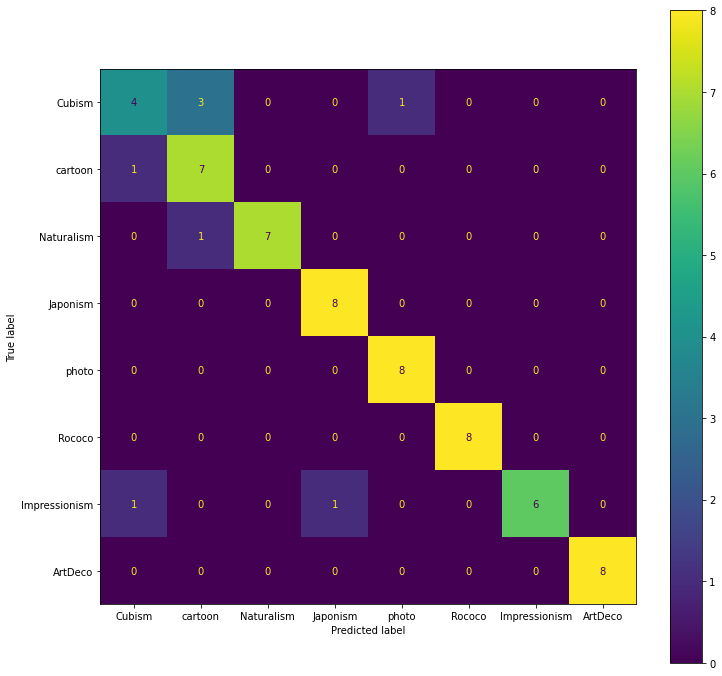

               precision    recall  f1-score   support

       Cubism       0.64      0.88      0.74         8
      cartoon       1.00      0.75      0.86         8
   Naturalism       0.89      1.00      0.94         8
     Japonism       0.89      1.00      0.94         8
        photo       1.00      1.00      1.00         8
       Rococo       1.00      1.00      1.00         8
Impressionism       1.00      0.88      0.93         8
      ArtDeco       0.67      0.50      0.57         8

     accuracy                           0.88        64
    macro avg       0.89      0.88      0.87        64
 weighted avg       0.89      0.88      0.87        64



In [97]:
def get_accuracy(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_matrix, display_labels=CLASSNUM_TO_LABEL.values()
    )
    disp.plot()
    plt.show()

    print(
        classification_report(
            y_true,
            y_pred,
            labels=list(CLASSNUM_TO_LABEL.keys()),
            target_names=list(CLASSNUM_TO_LABEL.values()),
        )
    )


get_accuracy(y_true, y_pred)

# Task 2

Here we generate embeddings and try to asess how good the classes are separated.

Another option is to try to cluster the embeddings and distinguish the outliers (see data analysis).

In [98]:
embedding_paths = glob.glob("/kaggle/input/bj-demo/images/*/*.jpg")

In [99]:
def get_feature(model, in_path):
    in_image = cv2.imread(in_path)
    with torch.no_grad():
        in_image = torch.tensor(cv2.cvtColor(in_image, cv2.COLOR_BGR2RGB))
        in_image = in_image.permute(2, 0, 1)
        in_image = torch.unsqueeze(in_image, 0)
        in_image = in_image.float() / 255.0
        prediction = model.get_embeddings(in_image)
    return torch.flatten(prediction).detach().cpu().numpy()

May be we did not need training above? 

The model, pretrained on imagenet, may give good results.

In [100]:
num_classes = len(os.listdir("/kaggle/input/bj-demo/images"))

embeddings = []
for emb_path in tqdm(embedding_paths):
    embeddings.append(get_feature(inference_model, emb_path))

embeddings_df = pd.DataFrame({"paths": embedding_paths, "embeddings": embeddings})

  0%|          | 0/1422 [00:00<?, ?it/s]

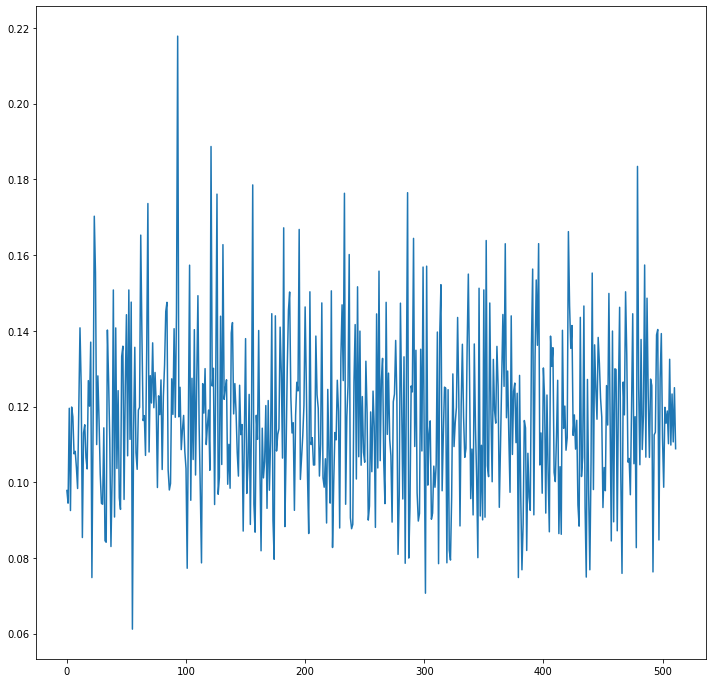

In [101]:
plt.plot(np.max(np.array(embeddings), axis=0))
plt.show()

The arcface embeddings already lie in range [0,1]. There is no need to normalize them.

In [102]:
# Get nice projection of embeddings into 2d-space
embeddings_2d = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(
    np.array(embeddings)
)

In [103]:
embeddings_df["embeddings_2d"] = embeddings_2d.tolist()
embeddings_df["gt_label"] = embeddings_df["paths"].apply(lambda x: x.split("/")[5])
embeddings_df["gt_labelnum"] = embeddings_df["gt_label"].apply(
    lambda x: LABEL_TO_CLASSNUM[x]
)

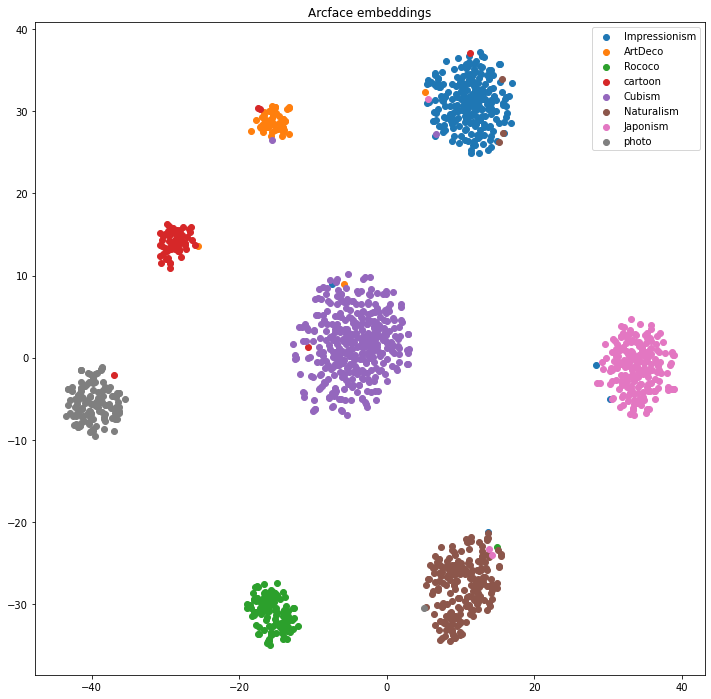

In [104]:
u_labels = embeddings_df["gt_label"].unique()
for i in u_labels:
    plt.scatter(
        np.array(
            embeddings_df[embeddings_df["gt_label"] == i]["embeddings_2d"].tolist()
        )[:, 0],
        np.array(
            embeddings_df[embeddings_df["gt_label"] == i]["embeddings_2d"].tolist()
        )[:, 1],
        label=i,
    )
plt.title("Arcface embeddings")
plt.legend()
plt.show()

Arcface can provide A LOT more effective embeddings, than conventional CNN

To asess the cluster quality we will use the [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

The score is calculated between two sets. Here we will find the score between every pair of classes.

! one-vs-all may be bad if the cluster is surrounded by others.

In [105]:
def calc_silhouette(classA: int, classB: int, df: pd.DataFrame, key: str) -> float:
    classA_df = embeddings_df[embeddings_df["gt_labelnum"] == classA]
    classB_df = embeddings_df[embeddings_df["gt_labelnum"] == classB]
    combined_df = pd.concat([classA_df, classB_df])
    return silhouette_score(
        combined_df[key].tolist(), combined_df["gt_labelnum"].tolist()
    )

In [106]:
combinations_list = list(
    itertools.combinations(list(embeddings_df["gt_labelnum"].unique()), 2)
)
classes_A = []
classes_B = []
silhouette_list = []
for item in combinations_list:
    classes_A.append(item[0])
    classes_B.append(item[1])
    silhouette_list.append(
        calc_silhouette(item[0], item[1], embeddings_df, key="embeddings")
    )
pretrained_silhouette_df = pd.DataFrame(
    {"Class A": classes_A, "Class B": classes_B, "silhouette score": silhouette_list}
)

In [107]:
pretrained_silhouette_df

,Class A,Class B,silhouette score
0,2,0,0.492342
1,2,5,0.515911
2,2,6,0.472113
3,2,1,0.572097
4,2,4,0.540760
5,2,3,0.517030
6,2,7,0.500560
7,0,5,0.463761
8,0,6,0.407384
9,0,1,0.575573


The silhouette score is MUCH better than the one CNN

It would be nice to remove dataset noise. One solution is to use OPTICS algorithm.

I have tried to cluster embeddings with OPTICS, but surprisingly did not achieve good result. The problem may be in [curse of dimensionality](https://towardsdatascience.com/curse-of-dimensionality-a-curse-to-machine-learning-c122ee33bfeb).

In [108]:
clusters_optics = OPTICS(min_samples=15, xi=0.001)
clusters_optics.fit(embeddings)

clusters_kmeans = KMeans(n_clusters=8, random_state=42)
clusters_kmeans.fit(embeddings)

embeddings_df["cluster_optics"] = clusters_optics.labels_
embeddings_df["cluster_kmeans"] = clusters_kmeans.labels_

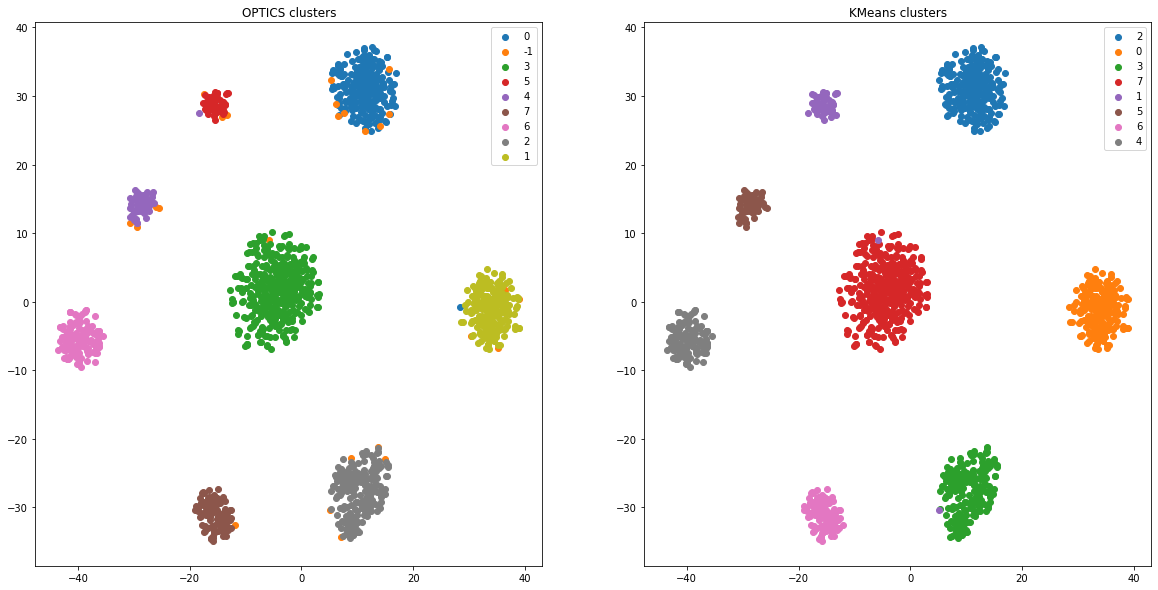

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

u_labels = embeddings_df["cluster_optics"].unique()
for i in u_labels:
    ax1.scatter(
        np.array(
            embeddings_df[embeddings_df["cluster_optics"] == i][
                "embeddings_2d"
            ].tolist()
        )[:, 0],
        np.array(
            embeddings_df[embeddings_df["cluster_optics"] == i][
                "embeddings_2d"
            ].tolist()
        )[:, 1],
        label=i,
    )
ax1.set_title("OPTICS clusters")
ax1.legend()

u_labels = embeddings_df["cluster_kmeans"].unique()
for i in u_labels:
    ax2.scatter(
        np.array(
            embeddings_df[embeddings_df["cluster_kmeans"] == i][
                "embeddings_2d"
            ].tolist()
        )[:, 0],
        np.array(
            embeddings_df[embeddings_df["cluster_kmeans"] == i][
                "embeddings_2d"
            ].tolist()
        )[:, 1],
        label=i,
    )
ax2.set_title("KMeans clusters")
ax2.legend()
plt.show()

Here OPTICS works perfect even at original dimension size.

The clusters are similar to classes from labeling and we can clearly see the outliers.

Note that there are much less outliers than with original CNN.

The KMeans is still applicable, but without outlier detection

# Task 3

Here we try to perform classification with gradient boosting.

In [110]:
test_files = glob.glob("/kaggle/temp/test/*/*.jpg")
test_files = ["/".join(x.split("/")[4:]) for x in test_files]

train_files = glob.glob("/kaggle/temp/trainval/*/*.jpg")
train_files = ["/".join(x.split("/")[4:]) for x in train_files]

In [111]:
def process_path(in_path):
    new_path = "/".join(in_path.split("/")[5:])
    return new_path


embeddings_df["paths2"] = embeddings_df["paths"].apply(process_path)

test_split = embeddings_df[embeddings_df["paths2"].isin(test_files)]
train_split = embeddings_df[embeddings_df["paths2"].isin(train_files)]
train_split_no_outliers = train_split[train_split["cluster_optics"] != -1]

len(test_split), len(train_split_no_outliers), len(embeddings_df)

(64, 1342, 1422, 54)

In [112]:
X_train = train_split["embeddings"].tolist()
y_train = train_split["gt_labelnum"].tolist()

X_train_no_outliers = train_split_no_outliers["embeddings"].tolist()
y_train_no_outliers = train_split_no_outliers["gt_labelnum"].tolist()

X_test = test_split["embeddings"].tolist()
y_test = test_split["gt_labelnum"].tolist()

X_test_no_outliers = test_split_no_outliers["embeddings"].tolist()

In [113]:
xgb_classifier = xgboost.XGBClassifier(n_estimators=8)
xgb_classifier_no_outliers = xgboost.XGBClassifier(n_estimators=8)

In [114]:
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

sample_weights_no_outliers = compute_sample_weight(
    class_weight="balanced", y=y_train_no_outliers
)

xgb_classifier.fit(X_train, y_train, sample_weight=sample_weights)
xgb_classifier_no_outliers.fit(
    X_train_no_outliers, y_train_no_outliers, sample_weight=sample_weights_no_outliers
)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=8, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [115]:
y_pred = xgb_classifier.predict(X_test)
y_pred_no_outliers = xgb_classifier_no_outliers.predict(X_test)

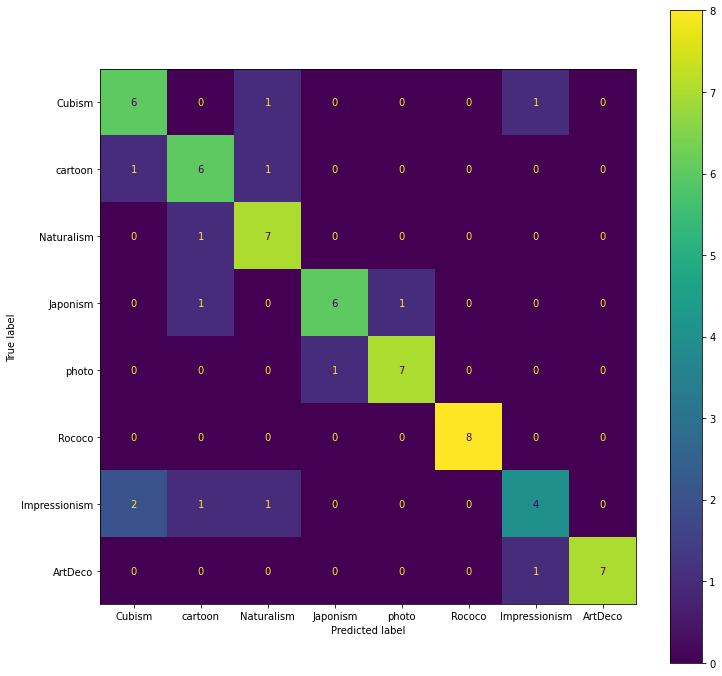

               precision    recall  f1-score   support

       Cubism       0.67      0.75      0.71         8
      cartoon       0.67      0.50      0.57         8
   Naturalism       0.88      0.88      0.88         8
     Japonism       0.86      0.75      0.80         8
        photo       1.00      0.88      0.93         8
       Rococo       1.00      1.00      1.00         8
Impressionism       0.70      0.88      0.78         8
      ArtDeco       0.67      0.75      0.71         8

     accuracy                           0.80        64
    macro avg       0.80      0.80      0.80        64
 weighted avg       0.80      0.80      0.80        64



In [116]:
get_accuracy(y_test, y_pred)

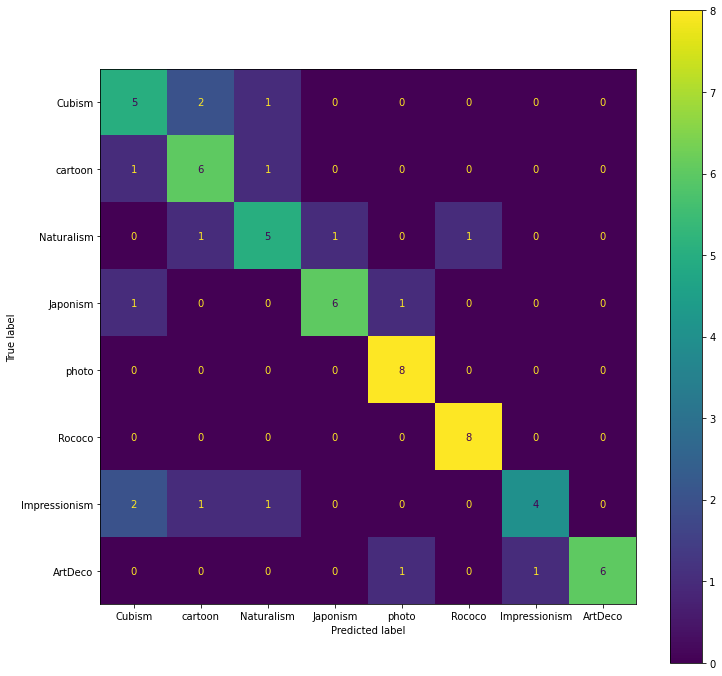

               precision    recall  f1-score   support

       Cubism       0.60      0.75      0.67         8
      cartoon       0.80      0.50      0.62         8
   Naturalism       0.80      1.00      0.89         8
     Japonism       0.86      0.75      0.80         8
        photo       1.00      0.75      0.86         8
       Rococo       0.89      1.00      0.94         8
Impressionism       0.62      0.62      0.62         8
      ArtDeco       0.56      0.62      0.59         8

     accuracy                           0.75        64
    macro avg       0.77      0.75      0.75        64
 weighted avg       0.77      0.75      0.75        64



In [117]:
get_accuracy(y_test, y_pred_no_outliers)

## Feature engineering

In [119]:
thresholds = np.sort(xgb_classifier.feature_importances_)
thresholds = thresholds[thresholds>0]
accuracies = []
nfeats = []

for thresh in tqdm(thresholds):
    
    # select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    # train model
    selection_model = xgboost.XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    
    # log accuracy
    accuracies.append(accuracy_score(y_test, predictions))
    nfeats.append(select_X_train.shape[1])
accuracies = np.array(accuracies)

  0%|          | 0/102 [00:00<?, ?it/s]

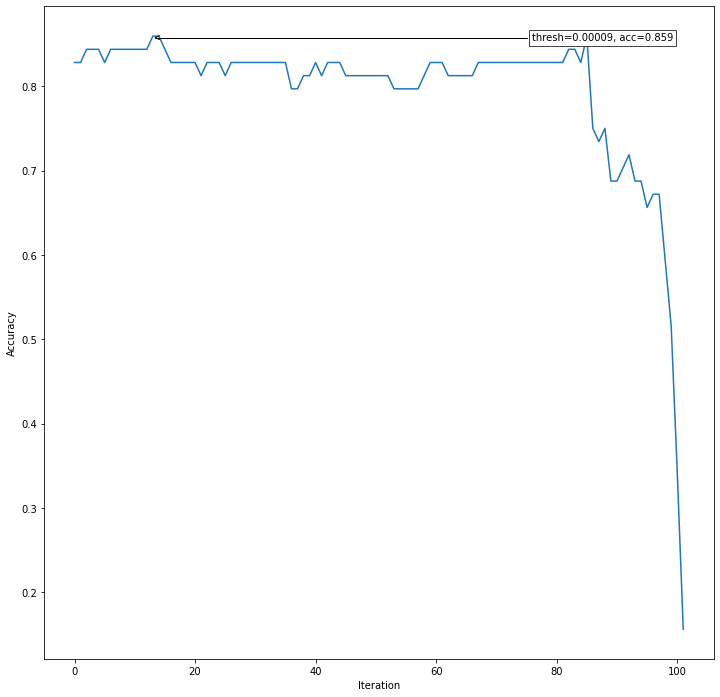

In [122]:
x_axis = np.linspace(0,len(accuracies)-1, len(accuracies))
def annot_max(x,y, ax=None):
    xmax = int(x[np.argmax(y)])
    thresh = thresholds[xmax]
    ymax = y.max()
    text= "thresh={:.5f}, acc={:.3f}".format(thresh, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)
    
fig, ax = plt.subplots()
ax.plot(x_axis, np.array(accuracies))
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
annot_max(x_axis, np.array(accuracies))

It is possible to improve the accuracy and inference speed by dropping unimportant features

In [123]:
best_thresh = thresholds[np.argmax(accuracies)]
selection = SelectFromModel(xgb_classifier, threshold=best_thresh, prefit=True)
select_X_train = selection.transform(X_train)
selection_model = xgboost.XGBClassifier()
selection_model.fit(select_X_train, y_train)
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)

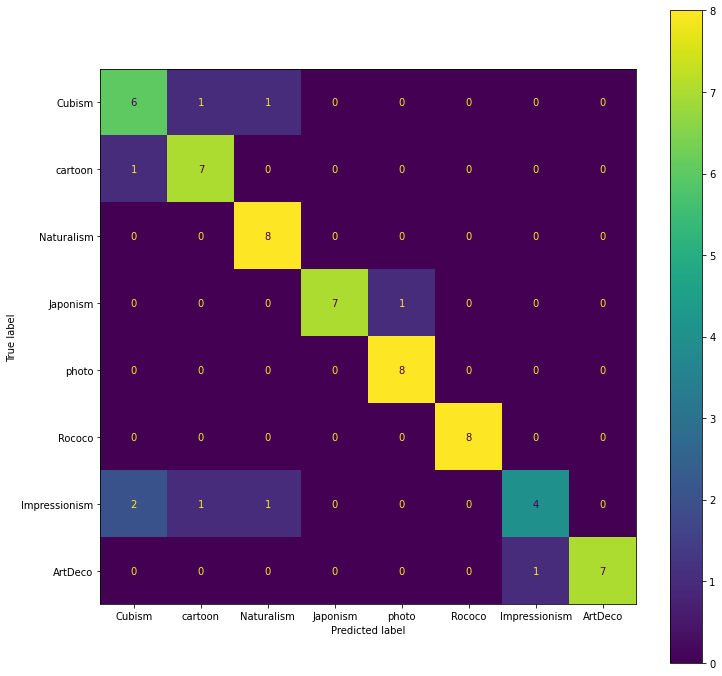

               precision    recall  f1-score   support

       Cubism       0.78      0.88      0.82         8
      cartoon       0.80      0.50      0.62         8
   Naturalism       0.89      1.00      0.94         8
     Japonism       1.00      0.88      0.93         8
        photo       1.00      0.88      0.93         8
       Rococo       1.00      1.00      1.00         8
Impressionism       0.80      1.00      0.89         8
      ArtDeco       0.67      0.75      0.71         8

     accuracy                           0.86        64
    macro avg       0.87      0.86      0.86        64
 weighted avg       0.87      0.86      0.86        64



In [124]:
get_accuracy(y_test, y_pred)

## Hyperparameter optimization

In [125]:
# Initialize domain space for range of values
booster_types = ["gbtree", "dart"]
space={
    'booster': hp.choice('booster', booster_types),
    'learning_rate': hp.uniform('learning_rate', 0.1, 0.6),
    'max_depth': hp.quniform("max_depth", 3, 9, 1),
    'subsample': hp.uniform("subsample", 0.5, 1.),    
    'n_estimators': hp.quniform('n_estimators', 80, 110, 1),
    'seed': 42
    }

In [126]:
# Define objective function
def objective(space):
    
    clf=xgboost.XGBClassifier(
        booster = space['booster'],
        learning_rate = space['learning_rate'],
        max_depth = int(space['max_depth']),
        subsample = space['subsample'],
        n_estimators =int(space['n_estimators']),
        n_jobs=2,
    )
    
    evaluation = [( select_X_train, y_train), ( select_X_test, y_test)]
    
    clf.fit(select_X_train, y_train,
            eval_set=evaluation,
            verbose=False)
    

    pred = clf.predict(select_X_test)
    accuracy = accuracy_score(y_test, pred)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [127]:
# Optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

100%|██████████| 100/100 [22:59<00:00, 13.79s/trial, best loss: -0.859375]


In [128]:
# Results
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'booster': 0, 'learning_rate': 0.13776990008076598, 'max_depth': 8.0, 'n_estimators': 99.0, 'subsample': 0.8658623495674971}


In [129]:
clf_best=xgboost.XGBClassifier(
        booster = booster_types[best_hyperparams['booster']],
        learning_rate = best_hyperparams['learning_rate'],
        max_depth = int(best_hyperparams['max_depth']),
        subsample = best_hyperparams['subsample'],
        n_estimators =int(best_hyperparams['n_estimators']),
    )

In [130]:
clf_best.fit(select_X_train, y_train)
y_pred = clf_best.predict(select_X_test)

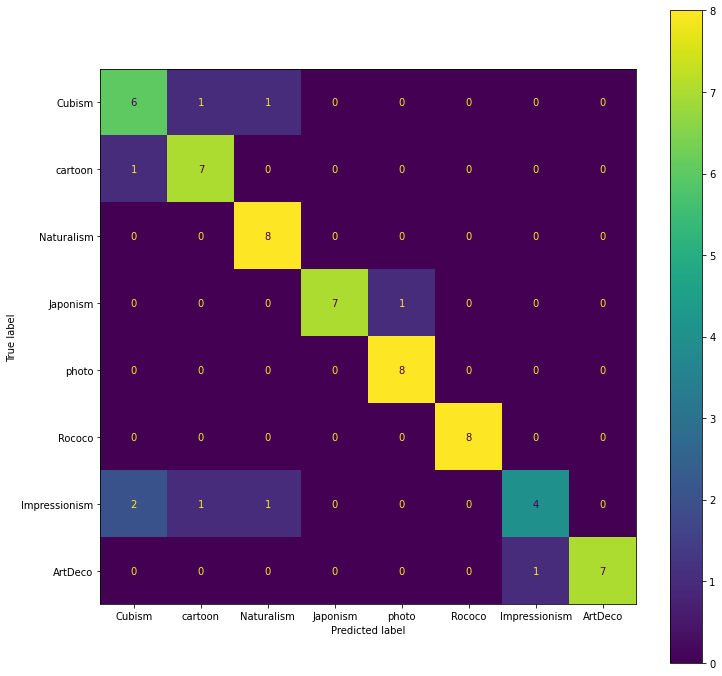

               precision    recall  f1-score   support

       Cubism       0.78      0.88      0.82         8
      cartoon       0.80      0.50      0.62         8
   Naturalism       0.89      1.00      0.94         8
     Japonism       1.00      0.88      0.93         8
        photo       1.00      0.88      0.93         8
       Rococo       1.00      1.00      1.00         8
Impressionism       0.80      1.00      0.89         8
      ArtDeco       0.67      0.75      0.71         8

     accuracy                           0.86        64
    macro avg       0.87      0.86      0.86        64
 weighted avg       0.87      0.86      0.86        64



In [131]:
get_accuracy(y_test, y_pred)

# Conclusion

Arcface gives the best results, probably, due to it's head (see https://arxiv.org/pdf/1801.07698.pdf) than conventional CNN and XGBoost, even with feature selection and hyperparameter tuning. The Arcface+XGBoost is still better than CNN+XGBoost, as the embeddings provided by Arcface are much more separated (proved by Sihlouette Score). A lot of samples that were classified as outliers with CNN are now ok. It is much easier to remove the outliers with ArcFace and OPTICS.

Here the hyperparameter tuning did not manage increase the accuracy.

The Arcface is also an effective tool against class imbalance.

The ideas for main improvement are provided in the first part of the task. The majority of them may be applied to the ArcFace baseline.